# Training a masconCUBE
A geodesyNET is but a new representation of the mass density of an irregular body.

One can see it as a parametrization of a continuous function $\rho(x,y,z)$ whose parameters $\eta_i$ (network weights and biases) are learned efficiently thanks to the SGD approach.

The question arises on how it compares with respect to the state-of-the-art in geodesy techniques. While any comparison to existing methods is bound to be unfair as geodesyNETs are the only representation that can learn the body shape and its interior structure simultaneously, we can introduce an alternative model (we call masconCUBE) that can be compared in fairness to GeodesyNET.

A masconCUBE is a cube full of mascons so that $N\times N\times N$ mascons $m_j$ are placed withing the unit volume $V$ in a regular grid. We may then consider the various masses $m_j$ as the parameters of a model to be learned from observations.

Differently from a geodesyNET, a masconCUBE does not represent the body density continuously, but other than this important detail the two representations have similar properties and hence can be compared once the various parameters $\eta_i$ for the network and $m_i$ for the masconCUBE are learned.

![alt text](figures/masconCUBE.png)

In this notebook we setup the learning procedure for a masconCUBE. Note that the value of the gravitational acceleration created by a masconCUBE at $\mathbf r_i$ is:
$$
\mathbf a_i = \sum_{j=1}^{N^3} \frac {m_j}{r_{ij}^3}{\mathbf r_{ij}}
$$
which means that each measurment of a gravitational acceleration results in linear relation so that at the end putting all measurements together one may write:
$$
\mathbf A \mathbf m = \mathbf b
$$
In most cases, when $N>20$ this system becomes to large to be solved and one must revert to alternative approaches, in particular gradient descent based.

In [2]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import scipy
import pickle as pk
import os
from collections import deque
import torchquad as tquad
tquad.set_log_level("CRITICAL")
from copy import deepcopy

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)
11:47:32|TQ-INFO| Initializing torchquad.


Available devices  1
__pyTorch VERSION: 1.10.0
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing a mascon model
For the purpose of this notebook we will be using, as ground truth, also a mascon model: the one of Eros.
Note though that the procedure in generic and one could also use a polyhedral gravity gound truth or other models.

In [5]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Hollow2.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = torch.tensor(mascon_points)
mascon_masses = torch.tensor(mascon_masses)

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  sample_01_cluster_4439
Number of mascons:  4922
Total mass:  tensor(1.0000, device='cpu')


C:\Users\DARIOI~1\AppData\Local\Temp/ipykernel_8328/2789023440.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mascon_points = torch.tensor(mascon_points)
C:\Users\DARIOI~1\AppData\Local\Temp/ipykernel_8328/2789023440.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mascon_masses = torch.tensor(mascon_masses)


<IPython.core.display.Javascript object>


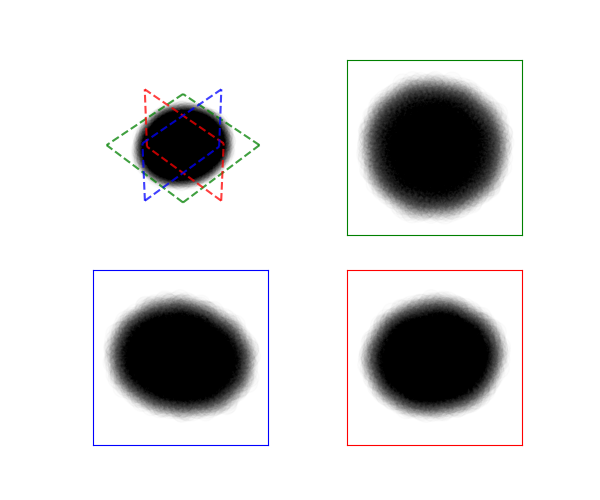

In [4]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Learning the masconCUBE model


In [18]:
# This is the number of mascons per side of our masconCUBE
N=45
print("MasconCUBE number of parameters is: ", N*N*N)
# Here we define the sqrt(m_j) or model parameters
mascon_masses_model = torch.rand((N*N*N,1))*2-1
mascon_masses_model = mascon_masses_model.requires_grad_(True)


MasconCUBE number of parameters is:  91125


In [19]:
# Here we define the points of the masconCUBE
X,Y,Z = torch.meshgrid(torch.linspace(-1,1, N), torch.linspace(-1,1, N), torch.linspace(-1,1, N), indexing='ij')
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
Z = Z.reshape(-1,1)
mascon_points_model = torch.concat((X,Y,Z), dim=1)

In [20]:
# Dimension of the batch size, i.e. number of points
# where the ground truth is compared to the predicted acceleration
# at each training epoch.
batch_size = 1000

# Loss. The normalized L1 loss. 
loss_fn = gravann.normalized_L1_loss

# The sampling method to decide what points to consider in each batch.
# In this case we sample points unifromly in a sphere and reject those that are inside the asteroid
targets_point_sampler = gravann.get_target_point_sampler(batch_size, 
                                                         limit_shape_to_asteroid="3dmeshes/Eros_lp.pk", 
                                                         method="spherical", 
                                                         bounds=[0,1])

# Here we set the optimizer
learning_rate = 1e-1
optimizer = torch.optim.Adam(params = [mascon_masses_model], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8, patience = 200, min_lr = 1e-8,verbose=True)

# And init the best results
best_loss = np.inf

# When a new network is created we init empty training logs
loss_log = []
weighted_average_log = []
running_loss_log = []
# .. and we init a loss trend indicators
weighted_average = deque([], maxlen=20)

In [21]:
# TRAINING LOOP (normal training, no use of any prior shape information)------------------------
# This cell can be stopped and started again without loosing memory of the training nor its logs
torch.cuda.empty_cache()
# The main training loop
for i in range(5000):
    # Each ten epochs we resample the target points
    if (i % 10 == 0):
        target_points = targets_point_sampler()
        # We compute the labels whenever the target points are changed
        labels = gravann.ACC_L(target_points, mascon_points, mascon_masses)
    
    # We compute the values predicted by the neural density field
    predicted = gravann.ACC_L(target_points, mascon_points_model, mascon_masses_model*mascon_masses_model)
    
    # We compute the scaling constant (k in the paper) used in the loss
    c = torch.sum(predicted*labels)/torch.sum(predicted*predicted)
    
    # We compute the loss
    loss = loss_fn(predicted.view(-1), labels.view(-1))
    
    # We store the model if it has the lowest fitness 
    # (this is to avoid losing good results during a run that goes wild)
    if loss < best_loss:
        best_model = deepcopy(mascon_masses_model)
        best_loss = loss
        print('New Best: ', loss.item())
    
    # Update the loss trend indicators
    weighted_average.append(loss.item())
    
    # Update the logs
    weighted_average_log.append(np.mean(weighted_average))
    loss_log.append(loss.item())
    
    # Print every i iterations
    if i % 25 == 0:
        wa_out = np.mean(weighted_average)
        print(f"It={i}\t loss={loss.item():.3e}\t  weighted_average={wa_out:.3e}\t  c={c:.3e}")
        
    # Zeroes the gradient (necessary because of things)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    # Perform a step in LR scheduler to update LR
    scheduler.step(loss.item())

New Best:  0.4658396244049072
It=0	 loss=4.658e-01	  weighted_average=4.658e-01	  c=1.226e-04
New Best:  0.3948202133178711
New Best:  0.3225540220737457
New Best:  0.277140736579895
New Best:  0.23988927900791168
New Best:  0.21162360906600952
New Best:  0.1860750913619995
New Best:  0.16599565744400024
New Best:  0.14686568081378937
New Best:  0.13054436445236206
New Best:  0.1304449588060379
New Best:  0.11720316112041473
New Best:  0.10510078817605972
New Best:  0.09355372935533524
New Best:  0.08334364742040634
New Best:  0.07413284480571747
New Best:  0.06667477637529373
New Best:  0.0601033978164196
New Best:  0.05480724200606346
New Best:  0.052001748234033585
It=25	 loss=5.200e-02	  weighted_average=9.826e-02	  c=3.456e-05
New Best:  0.04670244827866554
New Best:  0.042138777673244476
New Best:  0.03813260793685913
New Best:  0.03453988581895828
New Best:  0.03337637335062027
New Best:  0.03021300956606865
New Best:  0.02713896334171295
New Best:  0.024290334433317184
New Best

It=1975	 loss=4.690e-04	  weighted_average=7.026e-04	  c=1.326e-05
New Best:  0.0003732038603629917
It=2000	 loss=5.207e-04	  weighted_average=6.514e-04	  c=1.326e-05
It=2025	 loss=6.436e-04	  weighted_average=7.808e-04	  c=1.326e-05
It=2050	 loss=5.849e-04	  weighted_average=1.118e-03	  c=1.326e-05
It=2075	 loss=9.604e-04	  weighted_average=8.335e-04	  c=1.325e-05
It=2100	 loss=8.790e-04	  weighted_average=9.127e-04	  c=1.325e-05
It=2125	 loss=1.017e-03	  weighted_average=6.416e-04	  c=1.324e-05
It=2150	 loss=7.858e-04	  weighted_average=6.646e-04	  c=1.324e-05
It=2175	 loss=3.767e-04	  weighted_average=5.827e-04	  c=1.324e-05
New Best:  0.00035686217597685754
It=2200	 loss=4.552e-04	  weighted_average=5.397e-04	  c=1.324e-05
New Best:  0.0003464639594312757
It=2225	 loss=4.840e-04	  weighted_average=5.370e-04	  c=1.324e-05
It=2250	 loss=5.280e-04	  weighted_average=6.121e-04	  c=1.324e-05
It=2275	 loss=5.090e-04	  weighted_average=5.650e-04	  c=1.324e-05
It=2300	 loss=8.831e-04	  wei

It=4575	 loss=3.484e-04	  weighted_average=4.583e-04	  c=1.317e-05
It=4600	 loss=4.947e-04	  weighted_average=3.873e-04	  c=1.317e-05
It=4625	 loss=2.571e-04	  weighted_average=3.005e-04	  c=1.317e-05
It=4650	 loss=2.522e-04	  weighted_average=2.725e-04	  c=1.317e-05
It=4675	 loss=3.537e-04	  weighted_average=2.799e-04	  c=1.317e-05
It=4700	 loss=6.160e-04	  weighted_average=4.736e-04	  c=1.317e-05
It=4725	 loss=2.031e-04	  weighted_average=4.086e-04	  c=1.317e-05
It=4750	 loss=4.470e-04	  weighted_average=4.065e-04	  c=1.317e-05
Epoch  4760: reducing learning rate of group 0 to 5.4976e-03.
It=4775	 loss=3.079e-04	  weighted_average=4.271e-04	  c=1.317e-05
It=4800	 loss=4.340e-04	  weighted_average=3.007e-04	  c=1.317e-05
It=4825	 loss=3.362e-04	  weighted_average=3.375e-04	  c=1.317e-05
It=4850	 loss=5.306e-04	  weighted_average=3.790e-04	  c=1.317e-05
It=4875	 loss=5.669e-04	  weighted_average=6.226e-04	  c=1.317e-05
It=4900	 loss=3.532e-04	  weighted_average=4.133e-04	  c=1.317e-05


<IPython.core.display.Javascript object>


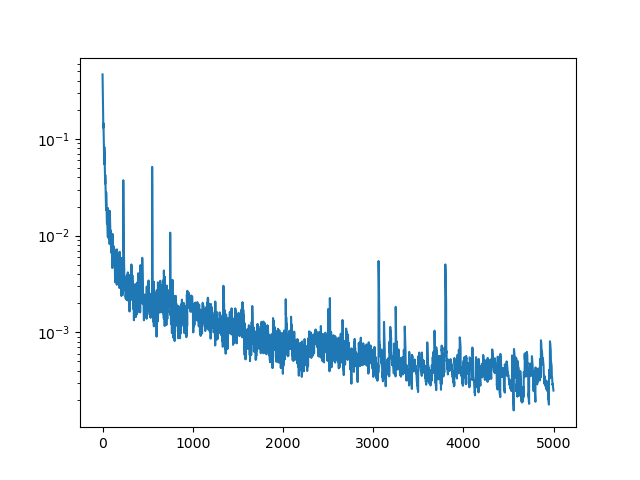

In [22]:
plt.figure()
plt.semilogy(loss_log)

In [25]:
# The actual value of the mascon masses is here obtained by squaring and normalizing
final_mascon_masses = best_model*best_model/torch.sum(best_model*best_model)

In [26]:
# Units of Length (this is Eros) (depend on how the the mascon model was created .... )
# These numbers matter for the final values quantitatively (but not qualitatively)
L  = 20413.864850997925
R0 = 16000/L

In [27]:
# Let us generate all Stokes coefficients up to order 7 and degree 7 (a square model)
l=7
m=7
stokesC_mascon, stokesS_mascon = gravann.mascon2stokes(mascon_points_model.cpu().numpy(), final_mascon_masses.view(-1).detach().cpu().numpy(), R0, l, m)

<IPython.core.display.Javascript object>


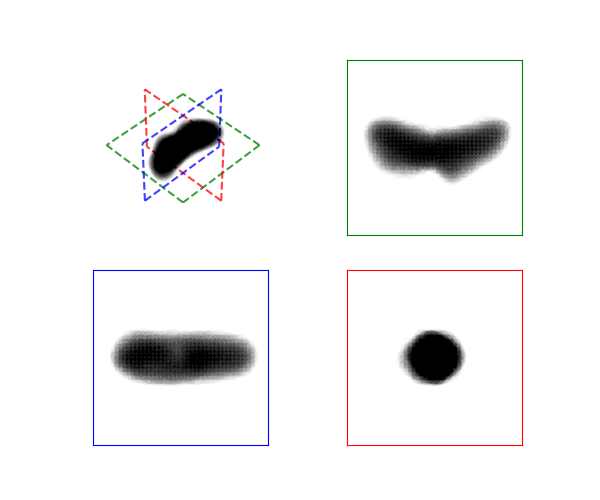

In [34]:
# Here we first trim the small values (for visualization purposes)
final_mascon_masses[final_mascon_masses<1e-5] = 0
# Then we plot
gravann.plot_mascon(mascon_points_model, final_mascon_masses.detach())

In [5]:
#with open("stokes/stokes_77_eros_mascon.pk", "wb") as file:
#    pk.dump((stokesC_mascon, stokesS_mascon), file)
#with open("mascons/Eros_masconCUBE.pk", "wb") as file:
#    pk.dump((mascon_points_model.cpu().numpy(), final_mascon_masses.view(-1).detach().cpu().numpy(), "Eros masconCUBE"), file)

In [23]:
results = gravann.validation_mascon(mascon_cube_points, mascon_cube_masses,mascon_points,mascon_masses, asteroid_pk_path="3dmeshes/Eros.pk", N=10000, batch_size=100, progressbar=True)

Computing validation...:  60%|█████████████████████████████▎                   | 44400/74244 [00:14<00:09, 3265.76it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|███████████████████████████████████▉             | 54400/74244 [00:28<00:06, 2856.88it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  86%|██████████████████████████████████████████▎      | 64100/74244 [00:40<00:03, 2953.45it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [00:50, 1485.67it/s]                                                                  


# Quantitative comparison with ground truth and geodestNET

In [7]:
with open("stokes/stokes_77_eros_gt.pk", "rb") as file:
    stokesC_gt, stokesS_gt = pk.load(file)
with open("stokes/stokes_77_eros_gann.pk", "rb") as file:
    stokesC_gann, stokesS_gann = pk.load(file)
with open("stokes/stokes_77_eros_mascon.pk", "rb") as file:
    stokesC_mascon, stokesS_mascon = pk.load(file)
with open("models/eros_masconCUBE.pk", "rb") as file:
    mascon_cube_points, mascon_cube_masses, name = pk.load(file)

In [6]:
# Here we compute the sorted indexes corresponding to the largest values
idxs = np.dstack(np.unravel_index(np.argsort(-np.abs(stokesC_gt.ravel())), (8, 8)))[0]
# We print to screen the three models
print(f"Harmonics \tGround Truth \tGeodesyNET \tMasconCUBE")
for pos in idxs:
    l,m = pos
    print(f"C_{l}{m}, \t\t{stokesC_gt[l][m]:2.3e}, \t{stokesC_gann[l][m]*1.00029:2.3e}, \t{stokesC_mascon[l][m]:2.3e}")

Harmonics 	Ground Truth 	GeodesyNET 	MasconCUBE
C_00, 		1.000e+00, 	1.000e+00, 	1.000e+00
C_22, 		8.766e-02, 	8.766e-02, 	8.765e-02
C_20, 		-5.281e-02, 	-5.281e-02, 	-5.280e-02
C_44, 		1.950e-02, 	1.941e-02, 	1.949e-02
C_42, 		-1.815e-02, 	-1.813e-02, 	-1.814e-02
C_40, 		1.304e-02, 	1.294e-02, 	1.303e-02
C_62, 		6.580e-03, 	6.583e-03, 	6.577e-03
C_64, 		-5.532e-03, 	-5.675e-03, 	-5.563e-03
C_60, 		-4.920e-03, 	-4.835e-03, 	-4.903e-03
C_66, 		4.122e-03, 	4.112e-03, 	4.120e-03
C_31, 		3.385e-03, 	3.397e-03, 	3.387e-03
C_33, 		-3.329e-03, 	-3.324e-03, 	-3.329e-03
C_55, 		-2.620e-03, 	-2.613e-03, 	-2.621e-03
C_51, 		-2.499e-03, 	-2.515e-03, 	-2.505e-03
C_53, 		2.339e-03, 	2.377e-03, 	2.329e-03
C_32, 		1.910e-03, 	1.924e-03, 	1.911e-03
C_71, 		1.660e-03, 	1.594e-03, 	1.660e-03
C_73, 		-1.459e-03, 	-1.476e-03, 	-1.449e-03
C_30, 		-1.427e-03, 	-1.431e-03, 	-1.428e-03
C_75, 		1.111e-03, 	1.149e-03, 	1.091e-03
C_52, 		-9.079e-04, 	-8.926e-04, 	-9.065e-04
C_54, 		8.065e-04, 	7.850e-04, 	7.999e-0